# NodePiece - Multilayer Perceptron
This notebook demonstrates the training of a Multilayer Perceptron model with trainable embeddings using the NodePiece algorithm.  We train the model on the IMDB dataset from [PyG datasets](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.IMDB) with TigerGraph as the data store. The dataset contains 3 types of vertices: 4278 movies, 5257 actors, and 2081 directors; and 4 types of edges: 12828 actor to movie edges, 12828 movie to actor edges, 4278 director to movie edges, and 4278 movie to director edges. Each vertex is described by a 0/1-valued word vector indicating the absence/presence of the corresponding keywords from the plot (for movie) or from movies they participated (for actors and directors). Each movie is classified into one of three classes, action, comedy, and drama according to their genre. The goal is to predict the class of each movie in the graph. NodePiece is compatible with pyTigerGraph versions 1.3+.

## Table of Contents
* [Data Processing](#data_processing)  
* [NodePiece Algorithm](#nodepiece_algorithm)
* [Train on Vertex Samples](#train_vertex)  
* [Inference](#inference)
* [Embedding Visualization](#viz)

## Data Processing <a name="data_processing"></a>

### Connect to TigerGraph

The `TigerGraphConnection` class represents a connection to the TigerGraph database. Under the hood, it stores the necessary information to communicate with the database. It is able to perform quite a few database tasks. Please see its [documentation](https://docs.tigergraph.com/pytigergraph/current/intro/) for details.

To connect your database, modify the `config.json` file accompanying this notebook. Set the value of `getToken` based on whether token auth is enabled for your database. Token auth is always enabled for tgcloud databases. 

In [2]:
from pyTigerGraph import TigerGraphConnection
import json

# Read in DB configs
with open('../../config.json', "r") as config_file:
    config = json.load(config_file)
    
conn = TigerGraphConnection(
    host=config["host"],
    username=config["username"],
    password=config["password"]
)

### Ingest Data

In [3]:
from pyTigerGraph.datasets import Datasets

dataset = Datasets("imdb")

conn.ingestDataset(dataset, getToken=config["getToken"])

A folder with name imdb already exists in ./tmp. Skip downloading.
---- Checking database ----
A graph with name imdb already exists in the database. Skip ingestion.
Graph name is set to imdb for this connection.


### Visualize Schema

In [4]:
from pyTigerGraph.visualization import drawSchema

drawSchema(conn.getSchema(force=True))

CytoscapeWidget(cytoscape_layout={'name': 'circle', 'animate': True, 'padding': 1}, cytoscape_style=[{'selecto…

## NodePiece Algorithm <a name="nodepiece_algorithm"></a>

The [NodePiece algorithm](https://arxiv.org/abs/2106.12144) was introduced as a way to both conserve the memory cost of vertex embeddings, as well as be able to generalize to unseen vertices during the testing process. This makes NodePiece a much more scalable approach for large, real-world graphs compared to other transductive techniques such as FastRP or Node2Vec. For more information about the algorithm, check out the author's [Medium post](https://towardsdatascience.com/nodepiece-tokenizing-knowledge-graphs-6dd2b91847aa).

We implement the NodePiece dataloader, which will allow us to iterate through batches of vertices. We take advantage of the callback functionality to process the batch into PyTorch tensors for less data manipulation in the training loop.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

In [5]:
def process_batch(batch):
    x = {"relational_context": torch.tensor(batch["Movie"]["relational_context"], dtype=torch.long), 
         "anchors": torch.tensor(batch["Movie"]["anchors"], dtype=torch.long), 
         "distance": torch.tensor(batch["Movie"]["anchor_distances"], dtype=torch.long),
         "feats": torch.tensor(np.stack(batch["Movie"]["x"].apply(lambda x: np.fromstring(x, sep=" ")).values), dtype=torch.float),
         "y": torch.tensor(batch["Movie"]["y"].astype(int))}
    return x

In [6]:
np_loader = conn.gds.nodepieceLoader(filter_by = "train_mask",
                                     batch_size = 128,
                                     compute_anchors = True,
                                     clear_cache = True,
                                     anchor_percentage = 0.1,
                                     v_feats = {"Movie": ["y", "x"], "Actor": [], "Director": []}, 
                                     target_vertex_types=["Movie"], 
                                     max_anchors=5,
                                     max_relational_context=5,
                                     e_types=conn.getEdgeTypes(),
                                     timeout=204_800_000,
                                     callback_fn = lambda x: process_batch(x))

Number of Anchors: 1161


## Train on Vertex Samples <a name="train_vertex"></a>
We train the model on batches of vertices. We utilize both the trainable embeddings provided by NodePiece, as well as the `x` feature vector stored as an attribute on all Movie vertices.

### Construct model and optimizer

In [8]:
class BaseNodePiece(nn.Module):
    def __init__(self, 
                 vocab_size:int,
                 sequence_length:int,
                 embedding_dim:int=768):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.sequence_length = sequence_length
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        torch.nn.init.xavier_uniform_(self.embedding.weight)

    def forward(self, x):
        anc_emb = self.embedding(x["anchors"])
        rel_emb = self.embedding(x["relational_context"])
        anc_emb += self.embedding(x["distance"])
        out = torch.concat([anc_emb, rel_emb], dim=1)
        return out

In [9]:
class MLP(nn.Module):
    def __init__(self,
                 embedding_model:BaseNodePiece,
                 out_dim:int=2,
                 num_hidden_layers:int=2,
                 hidden_dim:int=128):
        super().__init__()
        self.out_dim = out_dim
        self.num_layers = num_hidden_layers + 2
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden_layers)])
        self.out_layer = nn.Linear(hidden_dim, out_dim)
        self.in_layer = nn.Linear((embedding_model.embedding_dim*embedding_model.sequence_length)+3066, hidden_dim)
        self.emb_model = embedding_model

    def forward(self, x):
        feats = x["feats"]
        x = self.emb_model(x)
        x = torch.flatten(x, start_dim=1)
        x = torch.cat((x, feats), dim=1)
        x = self.in_layer(x)
        for layer in self.hidden_layers:
            x = F.dropout(F.relu(layer(x)), p=0.6)
        x = self.out_layer(x)
        x = F.log_softmax(x, dim=1)
        return x

In [10]:
emb_model = BaseNodePiece(vocab_size=np_loader.num_tokens, # add in special tokens
                 sequence_length=np_loader._payload["max_rel_context"] + np_loader._payload["max_anchors"],
                 embedding_dim=128)

model = MLP(emb_model, out_dim=3, num_hidden_layers=2, hidden_dim=128)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=5e-5)

In [11]:
np_loader.saveTokens("./npAncs.pkl")

In [12]:
valid_loader = conn.gds.nodepieceLoader(anchor_cache_attr="anchors", 
                                        filter_by = "val_mask",
                                        batch_size = 8192,
                                        v_feats = {"Movie": ["y", "x"], "Actor": [], "Director": []}, 
                                        target_vertex_types=["Movie"], 
                                        compute_anchors=False,
                                        max_anchors=5,
                                        max_relational_context=5,
                                        use_cache = True,
                                        e_types=conn.getEdgeTypes(),
                                        timeout=204_800_000,
                                        tokenMap="./npAncs.pkl",
                                        callback_fn = lambda x: process_batch(x))

### Train the model

In [13]:
import time
import numpy as np
from pyTigerGraph.gds.metrics import Accuracy, Accumulator


for i in range(10):
    acc = Accuracy()
    epoch_loss = Accumulator()
    start = time.time()
    for batch in np_loader:
        labels = batch["y"]
        out = model(batch)
        loss_val = loss(out, labels)
        acc.update(out.argmax(dim=1), labels)
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        epoch_loss.update(loss_val.item())
    end = time.time()
    val_acc = Accuracy()
    val_epoch_loss = Accumulator()
    for val_batch in valid_loader:
        with torch.no_grad():
            labels = val_batch["y"]
            out = model(val_batch)
            loss_val = loss(out, labels)
            val_acc.update(out.argmax(dim=1), labels)
            val_epoch_loss.update(loss_val.item())
    print("EPOCH {}: {}".format(i, epoch_loss.mean), 
          "Train Accuracy:", acc.value, 
          "Time:", end-start, 
          "Valid Loss: {}".format(val_epoch_loss.mean), 
          "Valid Accuracy:", val_acc.value)

EPOCH 0: 1.0881156623363495 Train Accuracy: 0.3775 Time: 0.4022190570831299 Valid Loss: 1.0691777467727661 Valid Accuracy: 0.37
EPOCH 1: 1.057876855134964 Train Accuracy: 0.4525 Time: 0.4199380874633789 Valid Loss: 1.0587773323059082 Valid Accuracy: 0.395
EPOCH 2: 0.9416443258523941 Train Accuracy: 0.525 Time: 0.43010425567626953 Valid Loss: 1.0353225469589233 Valid Accuracy: 0.4475
EPOCH 3: 0.616402730345726 Train Accuracy: 0.7925 Time: 0.4489316940307617 Valid Loss: 1.2440041303634644 Valid Accuracy: 0.5275
EPOCH 4: 0.20122080855071545 Train Accuracy: 0.9525 Time: 0.4667513370513916 Valid Loss: 2.2939810752868652 Valid Accuracy: 0.53
EPOCH 5: 0.1021158336661756 Train Accuracy: 0.97 Time: 0.49501729011535645 Valid Loss: 3.529735803604126 Valid Accuracy: 0.5225
EPOCH 6: 0.025811166735365987 Train Accuracy: 0.995 Time: 0.4997241497039795 Valid Loss: 4.4678778648376465 Valid Accuracy: 0.475
EPOCH 7: 0.020088251680135727 Train Accuracy: 0.9925 Time: 0.49360108375549316 Valid Loss: 6.28628

### Test the model

In [14]:
test_loader = conn.gds.nodepieceLoader(anchor_cache_attr="anchors", 
                                       filter_by = "test_mask",
                                       batch_size = 4096,
                                       v_feats = {"Movie": ["y", "x"], "Actor": [], "Director": []},
                                       target_vertex_types=["Movie"], 
                                       compute_anchors=False,
                                       max_anchors=5,
                                       max_relational_context=5,
                                       use_cache = True,
                                       e_types=conn.getEdgeTypes(),
                                       timeout=204_800_000,
                                       tokenMap="./npAncs.pkl",
                                       callback_fn=lambda x: process_batch(x))

In [15]:
acc = Accuracy()

epoch_loss = Accumulator()
start = time.time()
model.eval()
for batch in test_loader:
    labels = batch["y"]
    out = model(batch)
    loss_val = loss(out, labels)
    acc.update(out.argmax(dim=1), labels)
    epoch_loss.update(loss_val.item())
end = time.time()
print("Loss: {}, Accuracy: {}".format(epoch_loss.mean, acc.value), "Time:", end-start)

Loss: 4.582667350769043, Accuracy: 0.48591144335825187 Time: 2.114243984222412


## Visualize Embeddings <a name="viz"></a>

To view the embeddings, we sample 1000 Movie vertices from the graph and plot them in 2D using UMAP.

In [16]:
infer_loader = conn.gds.nodepieceLoader(anchor_cache_attr="anchors", 
                                        use_cache = True,
                                        clear_cache = False,
                                        v_feats = {"Movie": ["y", "x"], "Actor": [], "Director": []},
                                        target_vertex_types=["Movie"], 
                                        max_anchors=5,
                                        max_relational_context=5,
                                        e_types=conn.getEdgeTypes(),
                                        timeout=204_800_000,
                                        tokenMap="./npAncs.pkl",
                                        callback_fn = process_batch)

In [17]:
df = conn.getVertexDataFrame("Movie", limit=1_000)

In [18]:
df.head()

,v_id,id,x,y,train_mask,val_mask,test_mask,is_anchor,anchors
0,4119,4119,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,False,False,True,False,{'1088421899': 1}
1,4094,4094,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,False,False,True,False,{'897581108': 1}
2,4059,4059,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,False,False,True,False,{'933232699': 1}
3,4050,4050,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,False,False,True,False,"{'905969675': 5, '911212569': 5, '972029958': 3}"
4,3974,3974,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,False,False,True,False,"{'988807183': 3, '922747005': 3, '909115445': ..."


In [19]:
sample = [{"primary_id": x, "type": "Movie"} for x in df["v_id"]]

In [20]:
batch = infer_loader.fetch(sample)

In [21]:
embeddings = torch.flatten(emb_model(batch), start_dim=1)

In [22]:
print(embeddings.shape)

torch.Size([1000, 1280])

In [23]:
import umap.umap_ as umap

embd_x = umap.UMAP().fit_transform(embeddings.detach().numpy())

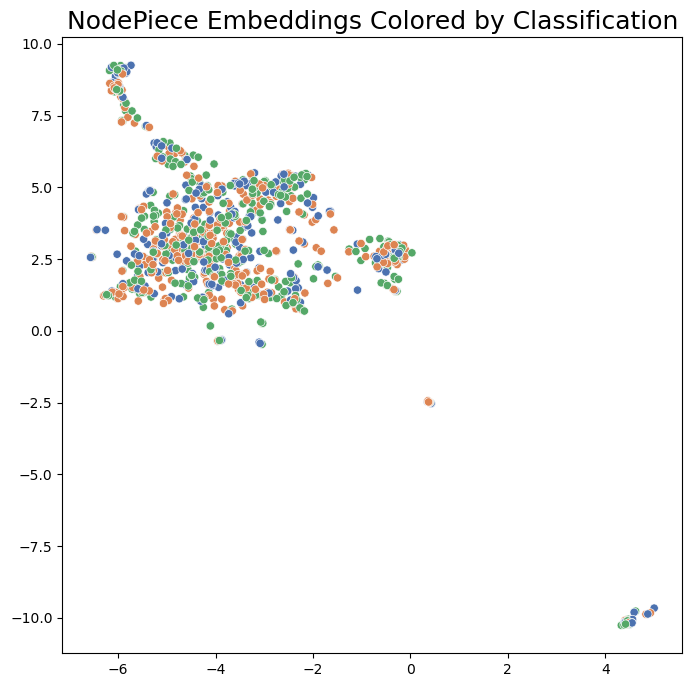

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
sns.set(font_scale=1)

palette = {}
for n, i in enumerate(set([0, 1, 2])):
    palette[i] = f'C{n}'
    
sns.scatterplot(ax=axs, x=embd_x.T[0], y=embd_x.T[1], hue=df["y"], palette=palette)
axs.get_legend().remove()
plt.title("NodePiece Embeddings Colored by Classification", fontsize=18)

plt.show()